In [1]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
SEED = 428
SIZE = 100

SMC_STEPS = 10000
MET_STEPS = 10000

# Data Generation

In [4]:
def gaussian_mixture(mu1=0, sigma1=1,
                     mu2=5, sigma2=2,
                     rho=0.5,
                     size=100, random_state=None):
    rnd = np.random.RandomState(random_state)
    x = []
    for _ in range(size):
        if rnd.rand() < rho:
            x.append(rnd.normal(loc=mu1, scale=sigma1))
        else:
            x.append(rnd.normal(loc=mu2, scale=sigma2))
    return np.array(x)

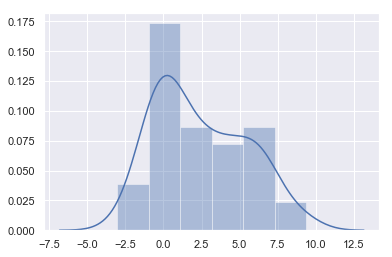

In [5]:
x = gaussian_mixture(rho=0.5, size=SIZE, random_state=SEED)
sns.distplot(x)

# Models

## Model 1
Fit to one Gaussian

In [6]:
with pm.Model() as model_1:
    mu = pm.Uniform("mu", lower=-10, upper=10)
    sigma = pm.Uniform("sigma", lower=0, upper=5)
    
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=x)

print(model_1.basic_RVs)

[mu_interval__, sigma_interval__, obs]


## Model 2
Two Gaussians with separate mu and sigma. Fix rho at 0.5.

In [7]:
with pm.Model() as model_2:
    w = pm.floatX([.5, .5])
    mu1 = pm.Uniform("mu1", lower=-10, upper=10)
    dmu = pm.Uniform("dmu", lower=0, upper=10)
    sigma1 = pm.Uniform("sigma1", lower=0, upper=5)
    sigma2 = pm.Uniform("sigma2", lower=0, upper=5)
    
    means = tt.zeros([2])
    means = tt.set_subtensor(means[0], mu1)
    means = tt.set_subtensor(means[1], mu1 + dmu)
    
    sigmas = tt.zeros([2])
    sigmas = tt.set_subtensor(sigmas[0], sigma1)
    sigmas = tt.set_subtensor(sigmas[1], sigma2)
    
    obs = pm.NormalMixture("obs", w=w, mu=means, sigma=sigmas, observed=x)

print(model_2.basic_RVs)

[mu1_interval__, dmu_interval__, sigma1_interval__, sigma2_interval__, obs]


## Model 3
Use separate `mu` and `sigma` for both Gaussians. rho uniformly distributed [0, 1].

In [8]:
with pm.Model() as model_3:
    rho = pm.Uniform("rho", lower=0, upper=1)
    
    mu1 = pm.Uniform("mu1", lower=-10, upper=10)
    dmu = pm.Uniform("dmu", lower=0, upper=10)
    
    sigma1 = pm.Uniform("sigma1", lower=0, upper=5)
    sigma2 = pm.Uniform("sigma2", lower=0, upper=5)
    
    w = tt.zeros([2])
    w = tt.set_subtensor(w[0], rho)
    w = tt.set_subtensor(w[1], 1 - rho)
    
    means = tt.zeros([2])
    means = tt.set_subtensor(means[0], mu1)
    means = tt.set_subtensor(means[1], mu1 + dmu)
    
    sigmas = tt.zeros([2])
    sigmas = tt.set_subtensor(sigmas[0], sigma1)
    sigmas = tt.set_subtensor(sigmas[1], sigma2)
    
    obs = pm.NormalMixture("obs", w=w, mu=means, sigma=sigmas, observed=x)

print(model_3.basic_RVs)

[rho_interval__, mu1_interval__, dmu_interval__, sigma1_interval__, sigma2_interval__, obs]


# Calculation of Bayes factors using sequential MC

## Marginal likelihood

Sample initial stage: ...
Stage: 0 Beta: 0.005 Steps: 25
Stage: 1 Beta: 0.038 Steps: 7
Stage: 2 Beta: 0.154 Steps: 3
Stage: 3 Beta: 0.489 Steps: 6
Stage: 4 Beta: 1.000 Steps: 3


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24624a58>,
      dtype=object)

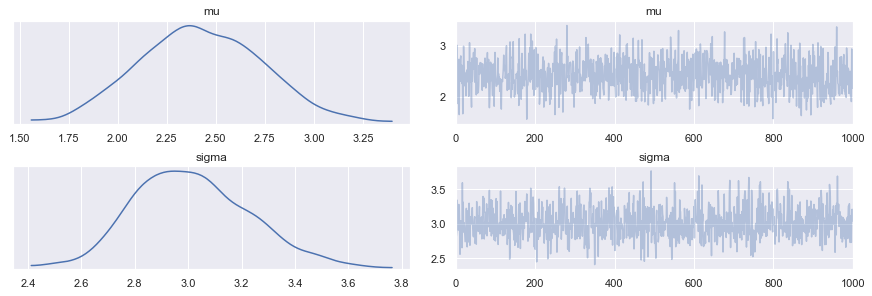

In [9]:
with model_1:
    tr_smc_m1 = pm.sample(SMC_STEPS, step=pm.SMC(), random_seed=SEED)
    
mllh_m1 = model_1.marginal_likelihood
pm.traceplot(tr_smc_m1[::10])

Sample initial stage: ...
Stage: 0 Beta: 0.013 Steps: 25
Stage: 1 Beta: 0.050 Steps: 13
Stage: 2 Beta: 0.124 Steps: 3
Stage: 3 Beta: 0.243 Steps: 10
Stage: 4 Beta: 0.440 Steps: 4
Stage: 5 Beta: 0.850 Steps: 8
Stage: 6 Beta: 1.000 Steps: 3


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c22d0ea58>,
      dtype=object)

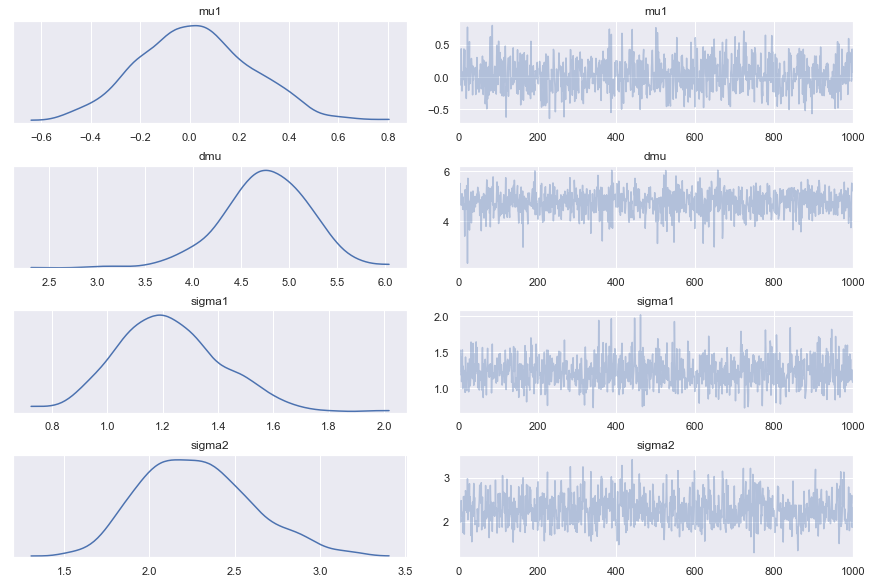

In [10]:
with model_2:
    tr_smc_m2 = pm.sample(SMC_STEPS, step=pm.SMC(), random_seed=SEED)
    
mllh_m2 = model_2.marginal_likelihood
pm.traceplot(tr_smc_m2[::10])

In [11]:
with model_3:
    tr_smc_m3 = pm.sample(SMC_STEPS, step=pm.SMC(), random_seed=SEED)
    
mllh_m3 = model_3.marginal_likelihood
pm.traceplot(tr_smc_m3[::10])

Sample initial stage: ...
Stage: 0 Beta: 0.011 Steps: 25
Stage: 1 Beta: 0.049 Steps: 15
Stage: 2 Beta: 0.138 Steps: 3
Stage: 3 Beta: 0.272 Steps: 17
Stage: 4 Beta: 0.445 Steps: 3
Stage: 5 Beta: 0.754 Steps: 18


OSError: [Errno 24] Too many open files

In [11]:
print("Log10 Marginal likelihood of model_1: %0.5f" % np.log10(mllh_m1))
print("Log10 Marginal likelihood of model_2: %0.5f" % np.log10(mllh_m2))
print("Log10 Marginal likelihood of model_3: %0.5f" % np.log10(mllh_m3))

Log10 Marginal likelihood of model_1: -111.31435
Log10 Marginal likelihood of model_2: -108.18939


## Bayes factors

In [12]:
print("Log10 Bayes factor, model_m2 over model_m1: %0.5f" %(np.log10(mllh_m2) - np.log10(mllh_m1)))
print("Log10 Bayes factor, model_m3 over model_m1: %0.5f" %(np.log10(mllh_m3) - np.log10(mllh_m1)))
print("Log10 Bayes factor, model_m3 over model_m2: %0.5f" %(np.log10(mllh_m3) - np.log10(mllh_m2)))

Log10 Bayes factor, model_m2 over model_m1: 3.12495
